In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *


In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '187570e379e046a4bc848c57e5c5c952')

In [5]:
!pip install bing-image-downloader
from bing_image_downloader import downloader
for q in ["adidas", "nike","reebok"]:
    downloader.download(q+" shoes", limit=1000, output_dir='shoes', adult_filter_off=True, force_replace=False, timeout=5)



[!!]Indexing page: 1

[%] Indexed 150 Images on Page 1.


[%] Downloading Image #1 from https://i.ytimg.com/vi/UUCKCsQD5-k/maxresdefault.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://volkyfootballboots.files.wordpress.com/2014/11/adidas-freefootball-messi-boost-football-shoe-4.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://www.newsshare.in/wp-content/uploads/2016/07/Adidas-Shoes-6.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images.the-house.com/adidas-varial-ii-mid-nba-shoes-blk-light-granite-white-15.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://nicershoes.com/wp-content/uploads/2017/11/best-Adidas-Running-Shoes.jpg
[!] Issue getting: https://nicershoes.com/wp-content/uploads/2017/11/best-Adidas-Running-Shoes.jpg
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading Image #5 from https://jeracgallero.files.wordpress.com/2014/11/an_adidas_shoe.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://st

In [4]:
def search_images_bing(key, term, max_images: int = 200, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [5]:
results = search_images_bing(key, 'nike')
ims = results.attrgot('content_url')
len(ims)

150

In [3]:
path = Path('shoes')
fns = get_image_files(path)
fns

(#3000) [Path('shoes/adidas/Image_1.jpg'),Path('shoes/adidas/Image_10.jpg'),Path('shoes/adidas/Image_100.jpg'),Path('shoes/adidas/Image_1000.jpg'),Path('shoes/adidas/Image_101.jpg'),Path('shoes/adidas/Image_102.jpg'),Path('shoes/adidas/Image_103.jpg'),Path('shoes/adidas/Image_104.jpg'),Path('shoes/adidas/Image_105.jpg'),Path('shoes/adidas/Image_106.jpg')...]

In [4]:
failed = verify_images(fns)
failed

(#0) []

In [5]:
failed.map(Path.unlink);

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


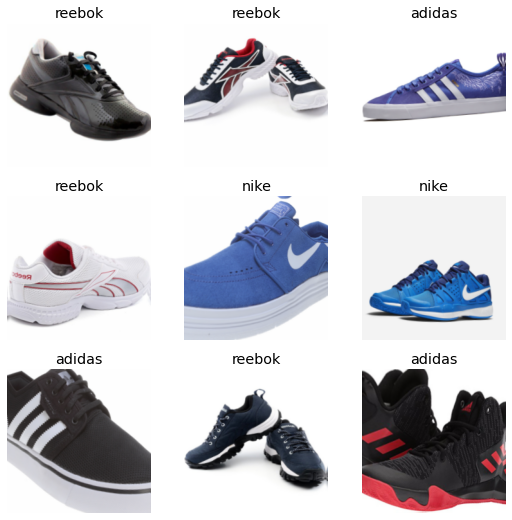

In [6]:
shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.8),
    batch_tfms=aug_transforms())
dls = shoes.dataloaders(path)
dls.show_batch()

In [7]:
#learn = cnn_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(),metrics=error_rate)
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(),metrics=error_rate)
learn.fine_tune(25)

epoch,train_loss,valid_loss,error_rate,time
0,0.842346,0.392176,0.096667,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.246717,0.076931,0.023333,01:25
1,0.128438,0.030674,0.011667,01:24
2,0.072077,0.017204,0.006667,01:26
3,0.051269,0.030514,0.010000,01:26
4,0.044387,0.043543,0.006667,01:24
5,0.045201,0.156378,0.045000,01:24
6,0.059077,0.145422,0.031667,01:25
7,0.052921,0.054097,0.016667,01:24
8,0.044915,0.046741,0.013333,01:24
9,0.031538,0.013524,0.003333,01:25


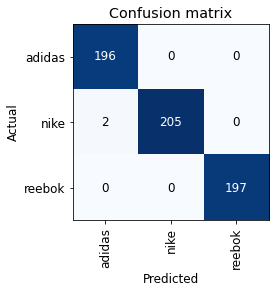

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

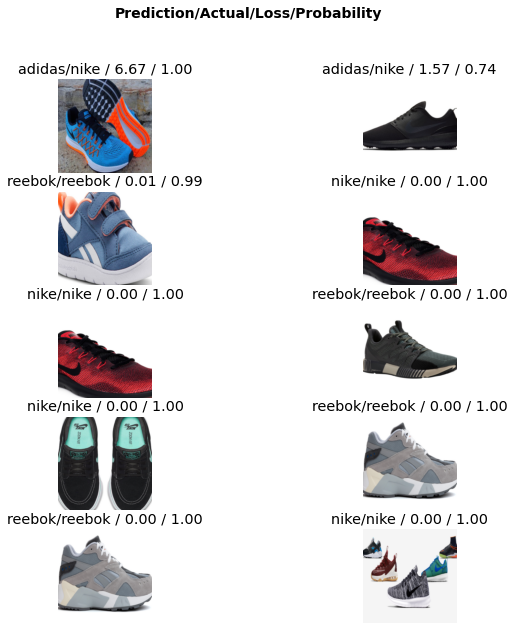

In [9]:
interp.plot_top_losses(10, nrows=5,figsize=(10,10))
#가장 손실값이 높은 샘플

In [10]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [42]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [11]:
learn.export()

In [12]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [13]:
learn_inf = load_learner(path/'export.pkl')

In [18]:
learn_inf.predict('images/nike.jpg')

('nike shoes',
 TensorImage(1),
 TensorImage([1.4123e-03, 9.9831e-01, 2.7512e-04]))

In [19]:
learn_inf.dls.vocab

['adidas shoes', 'nike shoes', 'reebok shoes']

# App

In [20]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [21]:
img = PILImage.create(btn_upload.data[-1])

In [22]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [23]:
pred,pred_idx,probs = learn_inf.predict(img)

In [24]:
lbl_pred = widgets.Label()
lbl_pred.value = 'Pleased choose an image'
btn_run = widgets.Button(description='Classify')


In [25]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

## VBox

In [26]:
VBox([widgets.Label('Select your shoes!'), 
      btn_upload, btn_run, out_pl, lbl_pred])